In [16]:
from pathlib import Path
import dill
import pyro

import numpy as np
import torch
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scripts.lga.utils import *

In [56]:
checkpoint_dir = Path.cwd().resolve() / "checkpoints"

n_samples = 800

all_service_time_samples = {
    "failure": [],
    "nominal": [],
}

for day in range(8, 29):
    nominal_days = [
        1,2,3,4,5,7,9,
        10,12,13,14,15,16,
        20,24,25,26,27,28,29
    ]
    nominal = day in nominal_days
    group = "nominal" if nominal else "failure"
    day_dir = checkpoint_dir / f"[LGA]_{group}_[2019-07-{day:02d}]"
    output_dict_path = day_dir / "final/output_dict.pkl"
    # guide_path = day_dir / "900/guide.pth"

    with open(output_dict_path, 'rb') as f:
        output_dict = dill.load(f)

    model = output_dict["model"]
    guide = output_dict["guide"]
    states = output_dict["states"]
    dt = output_dict["dt"]

    # guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
    # guide.load_state_dict()
    
    print(guide)

    print(day)
    with pyro.plate("samples", n_samples, dim=-1):
        posterior_samples = guide(states, dt)

    for key, samples in posterior_samples.items():
        posterior_samples[key] = samples.detach().cpu().numpy()

    service_time_samples = posterior_samples["LGA_0_mean_service_time"]

    all_service_time_samples[group].append(service_time_samples)
    # turnaround_time_samples = posterior_samples["LGA_0_mean_turnaround_time"]
    # base_cancel_prob_samples = np.exp(-posterior_samples["LGA_0_base_cancel_neg_logprob"])
    # initial_aircraft_samples = np.exp(posterior_samples["LGA_log_initial_available_aircraft"])

# for group, samples_list in all_service_time_samples:
#     all_service_time_samples[group] = np.concatenate(samples_list)

# print(all_service_time_samples)


AutoMultivariateNormal()
8
AutoMultivariateNormal()
9


RuntimeError: The expanded size of the tensor (2210) must match the existing size (2198) at non-singleton dimension 2.  Target sizes: [800, 2210, 2210].  Tensor sizes: [2198, 2198]

/var/folders/7r/dc0lww4500zgz6xz8bvdkhd00000gn/T/ipykernel_31652/3438437617.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


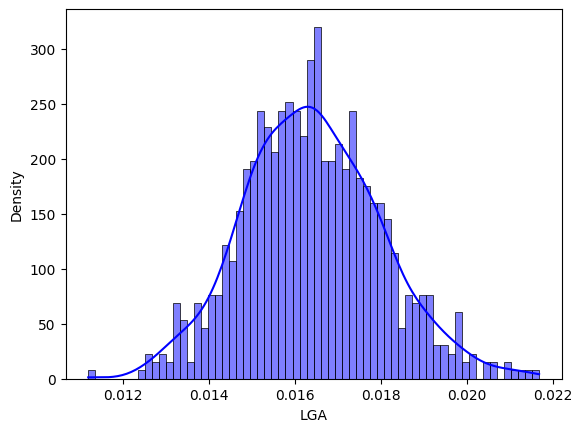

In [41]:
plotting_df = pd.DataFrame(
    {
        "LGA": service_time_samples,
        "type": "Posterior",
    }
)

fig, ax = plt.subplots()
sns.histplot(
    x="LGA",
    data=plotting_df,
    ax=ax,
    bins=64,
    stat="density",
    color="blue",
    kde=True,
)

fig.show()